In [1]:
import numpy as np 
import pandas as pd
import os 
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RandomizedSearchCV
from xgboost.sklearn import XGBRegressor
from sklearn.feature_selection import SelectFromModel

from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

In [3]:
def param_randomizedtune_pipline(model, X_train, X_test, y_train, y_test, param_grid, plot_flag = True):

    rs_clf = RandomizedSearchCV(model, 
    param_grid, 
    n_iter=10, 
    n_jobs = 8,
    cv = 10,
    scoring='median_absolute_error',
    refit = True, 
    random_state = 10086, verbose = 0)

    rs_clf.fit(X_train, y_train)

    score = rs_clf.best_score_
    param_recommend = rs_clf.best_params_

    train_pred = rs_clf.predict(X_train)
    train_pred = train_pred.reshape(y_train.shape)
    test_pred = rs_clf.predict(X_test)
    test_pred = test_pred.reshape(y_test.shape)

    print('Training Median Absolute Error Ratio %.2f'%(100*np.divide(np.abs(train_pred - y_train),y_train).mean()))
    print('Testing Median Absolute Error Ratio %.2f'%(100*np.divide(np.abs(test_pred - y_test),y_test).mean()))


    if plot_flag:
        plt.scatter(y_train, train_pred, color = 'blue', label = 'Train')
        plt.scatter(y_test, test_pred, color = 'red', label = 'Test')
        plt.plot([y_train.min(), y_train.max()],[y_train.min(), y_train.max()], color = 'black', linewidth = 2)
        plt.xlabel('Actual Median DS Inensity (g)')
        plt.ylabel('Predicted Median DS Intensity (g)')
        plt.legend()

    return rs_clf

def param_bayesiantune_pipline(model, param_range, X_train, X_test, y_train, y_test, init_points, n_iter):
    def cross_val_loss():
        return cross_val_score(model, X_train, y_train, cv = 10).median() 

    optimizer = BayesianOptimization(f = cross_val_loss,
                                    pbounds = param_range,
                                    random_state = 10086)
    optimizer.maximize(init_points, n_iter)

    param_recommend = optimizer.max()

    model_best = model(param_recommend)
    model_best.fit(X_train, y_train)

    train_pred = model_best.fit(X_train)
    test_pred = model_best.predict(X_test)

    print('Training Median Absolute Error Ratio %.2f'%(100*np.divide(np.abs(train_pred - y_train),y_train).mean()))
    print('Testing Median Absolute Error Ratio %.2f'%(100*np.divide(np.abs(test_pred - y_test),y_test).mean()))


    if plot_flag:
        plt.scatter(y_train, train_pred, color = 'blue', label = 'Train')
        plt.scatter(y_test, test_pred, color = 'red', label = 'Test')
        plt.plot([y_train.min(), y_train.max()],[y_train.min(), y_train.max()], color = 'black', linewidth = 2)
        plt.xlabel('Actual Median DS Inensity (g)')
        plt.ylabel('Predicted Median DS Intensity (g)')
        plt.legend()

    return model_best


In [4]:
param_grid = {'num_feature':[5,10,15,20],
'eta':[0.01,0.015,0.02,0.025,0.05,0.1,0.5,1.0],
'gamma':[0, 0.001,0.01,0.015,0.02,0.025,0.03,0.05,0.1,0.5],
'max_depth':[100,200,300,400,500,600,700,800,1000,2000],
'subsample':[0.1,0.2,0.3,0.4,0.5,0.8,1],
'lambda':[0,0.1,0.2,0.3,0.4,0.5,0.8,1.0],
'alpha':[0,0.1,0.2,0.3,0.4,0.5,0.8,1.0]}

# Retrofitted Building Model

In [5]:
os.chdir(r'C:\Users\User\StochasticOptimization\Desktop\XGBoostPipline')
# Read in data
Retrofit_TrainTest_DesignMatrix = pd.read_csv(r'RetrofitDsMedianRatio\RetrofitRatioTrainTestMatrix.csv')
Retrofit_Edge_DesignMatrix = pd.read_csv(r'RetrofitDsMedianRatio\RetrofitRatioEdgeMatrix.csv')
Retrofit_Verification_DesignMatrix = pd.read_csv(r'RetrofitDsMedianRatio\RetrofitRatioVerificationMatrix.csv')

Retrofit_TrainTestDSMedian_Ratio = pd.read_csv('RetrofitDsMedianRatio\DSMedianRatio_TrainTest.csv')
Retrofit_EdgeDSMedian_Ratio = pd.read_csv('RetrofitDsMedianRatio\DSMedianRatio_Edge.csv')
Retrofit_VerificationDSMedian_Ratio = pd.read_csv('RetrofitDsMedianRatio\DSMedianRatio_Verification.csv')

[11:54:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Median Absolute Error Ratio 2.48
Testing Median Absolute Error Ratio 6.91


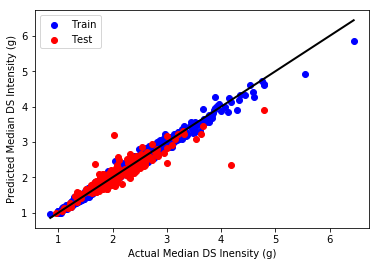

In [9]:
# reXGB_Complete = param_randomizedtune_pipline(XGBRegressor(), Retrofit_TrainTest_DesignMatrix, Retrofit_Verification_DesignMatrix, np.divide(DamageState_Retrofit['Complete'], np.repeat(DamageState_Existing['Complete'],5)), 
# np.divide(DamageState_Verification.loc[32:,'Complete'], pd.concat([DamageState_Verification.loc[0:31,'Complete']]*4)), param_grid, plot_flag = True)

# X_train, X_test, y_train, y_test = train_test_split(Retrofit_TrainTest_DesignMatrix.append(Retrofit_Verification_DesignMatrix), Retrofit_TrainTestDSMedian_Ratio.append(Retrofit_VerificationDSMedian_Ratio) ,test_size = 0.1)
# X_train = X_train.append(Retrofit_Edge_DesignMatrix)
# y_train = y_train.append(Retrofit_EdgeDSMedian_Ratio)
X_train, X_test, y_train, y_test = train_test_split(Retrofit_TrainTest_DesignMatrix.append(Retrofit_Verification_DesignMatrix), Retrofit_TrainTestDSMedian_Ratio.append(Retrofit_VerificationDSMedian_Ratio) ,test_size = 0.1)
X_train = X_train.append(Retrofit_Edge_DesignMatrix)
y_train = y_train.append(Retrofit_EdgeDSMedian_Ratio)
reXGB_Complete = param_randomizedtune_pipline(XGBRegressor(), X_train, X_test, y_train.iloc[:,3], y_test.iloc[:,3], param_grid, plot_flag = True)

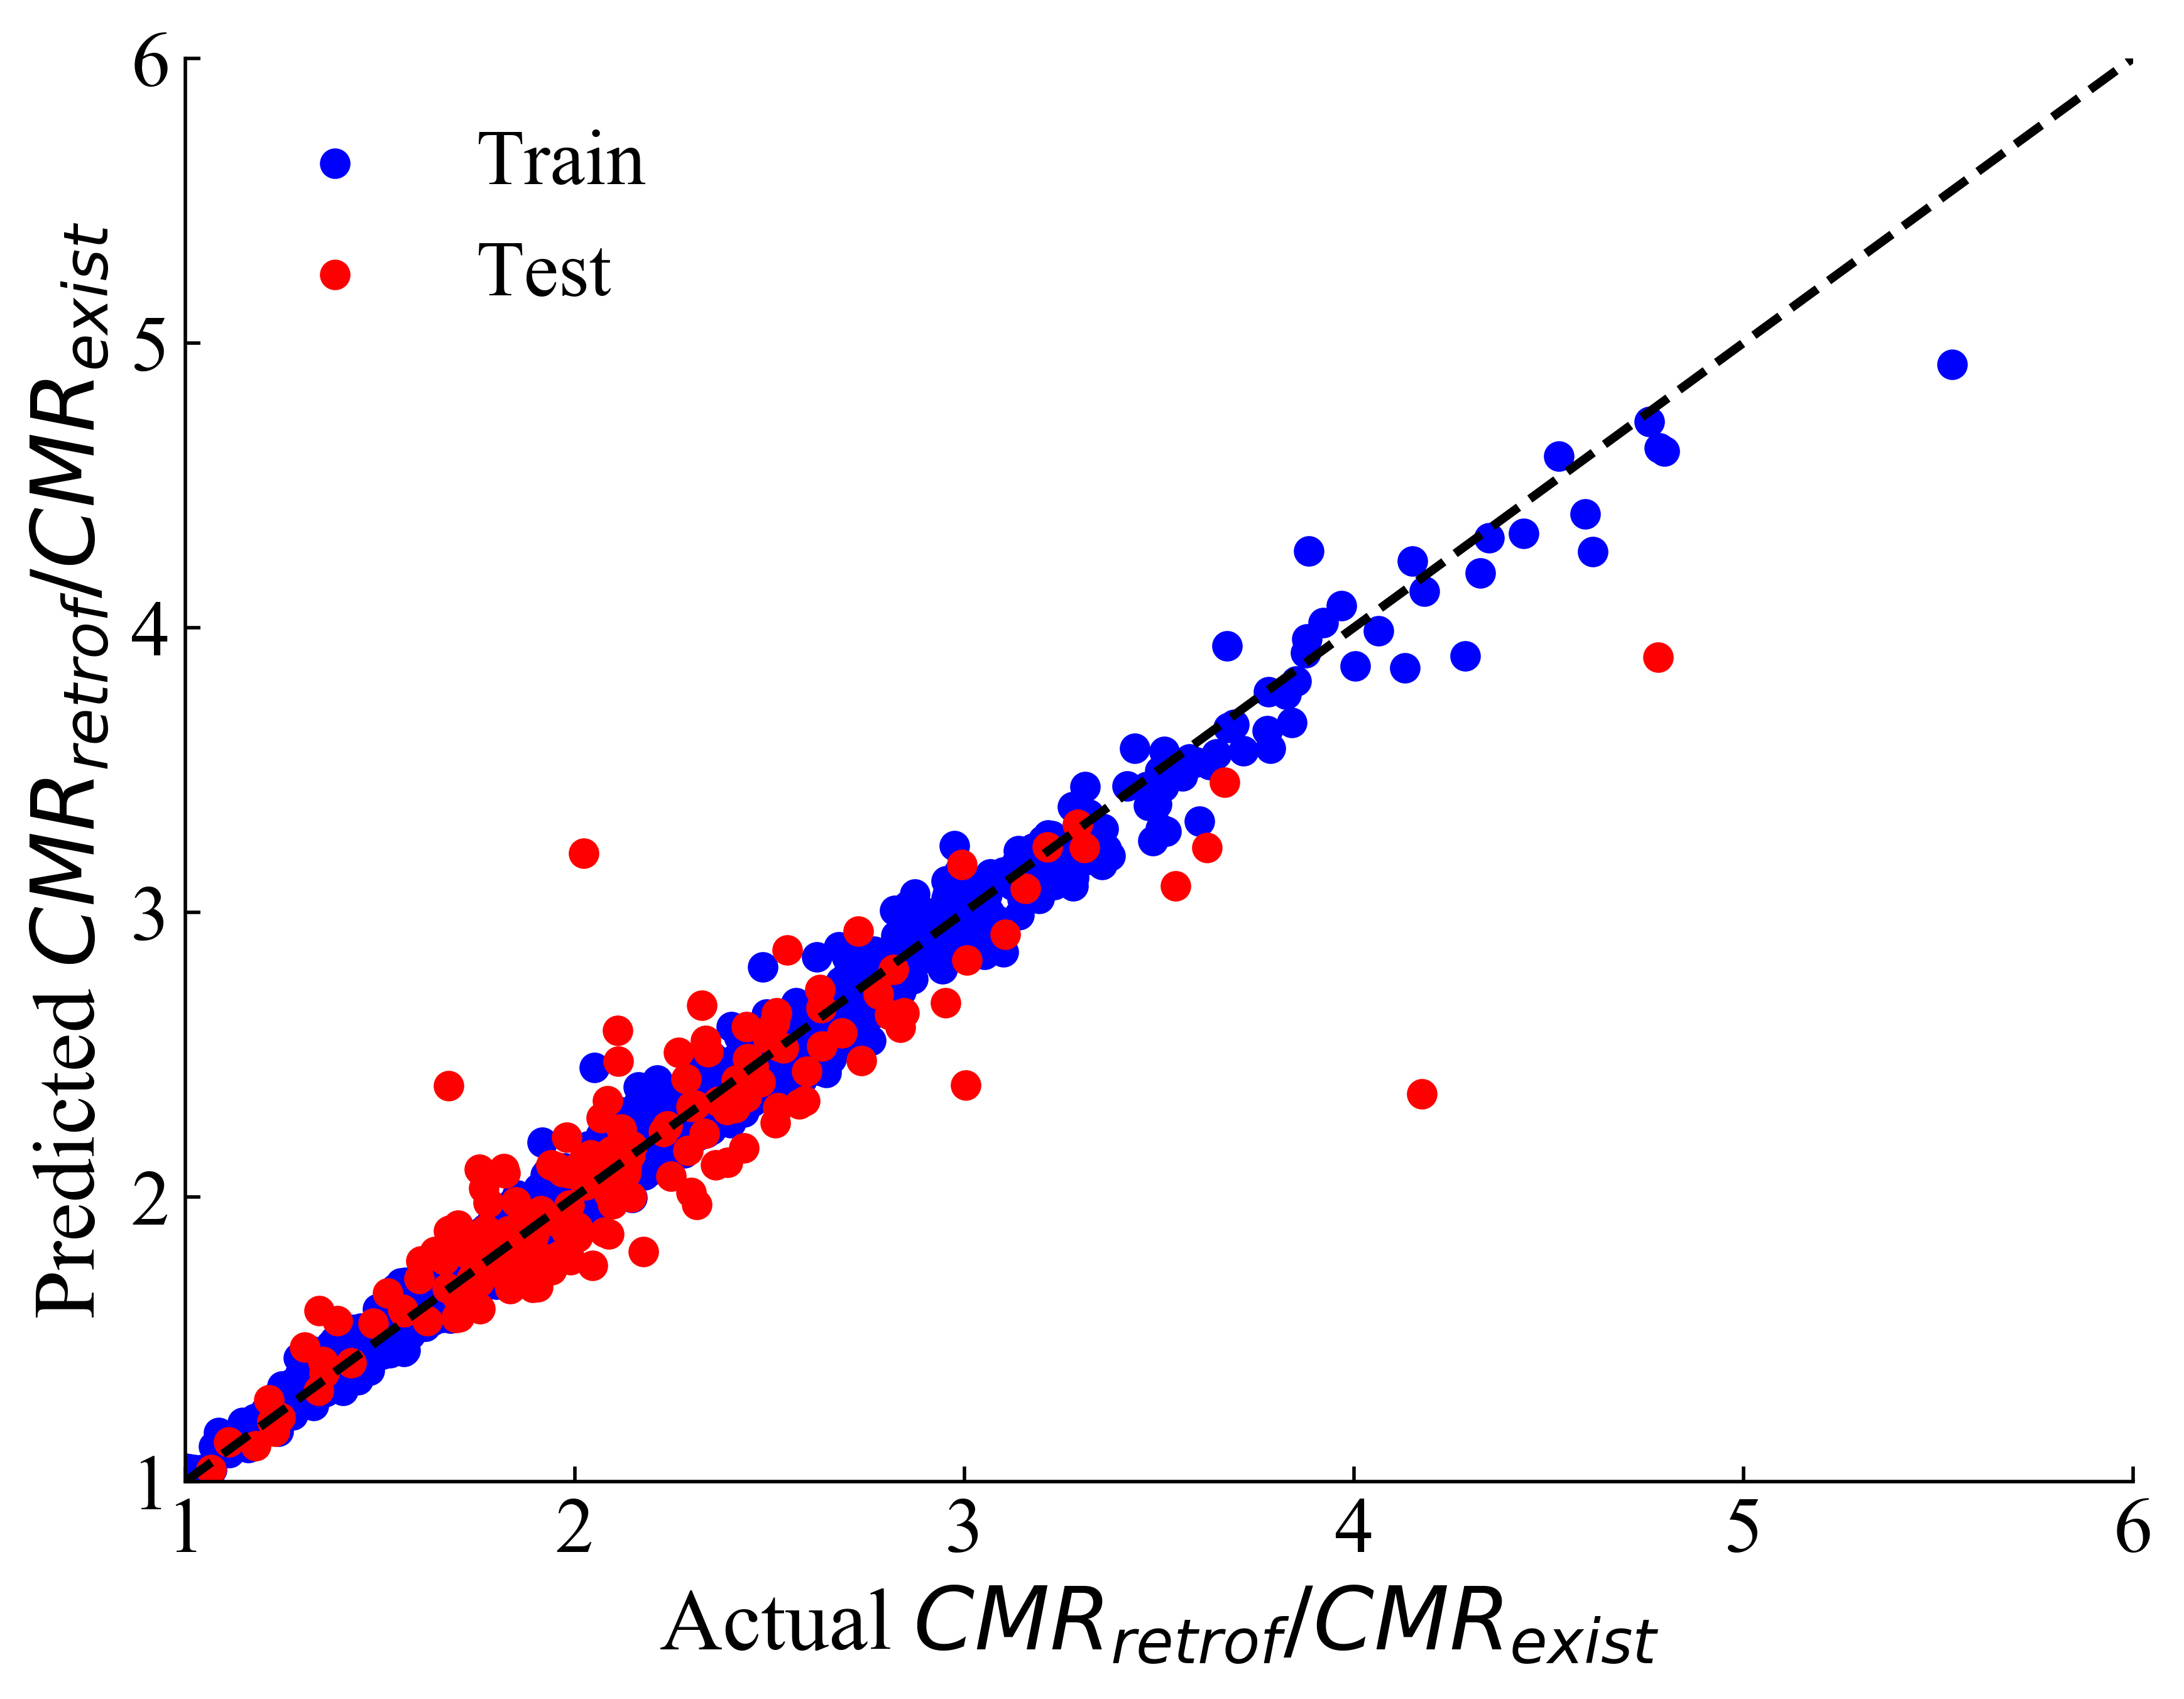

In [10]:
import seaborn as sns
font = {'fontname':'Times New Roman', 'size' : 20}
fig, ax = plt.subplots(figsize=(8,6), dpi=500)
ax.scatter(y_train.iloc[:,3], reXGB_Complete.predict(X_train), color = 'blue', label = 'Train')
ax.scatter(y_test.iloc[:,3], reXGB_Complete.predict(X_test), color = 'red', label = 'Test')
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
# plt.plot([y_train.min(), y_train.max()],[y_train.min(), y_train.max()], color = 'black', linewidth = 2)
plt.xlim([1,6])
plt.xticks( fontname = 'Times New Roman', fontsize = 18)
plt.ylim([1,6])
plt.yticks(fontname = 'Times New Roman', fontsize = 18)
plt.xlabel('Actual $CMR_{retrof} / CMR_{exist}$', **font)
plt.ylabel('Predicted $CMR_{retrof} / CMR_{exist}$', **font)
plt.legend(frameon = False, prop =  {"family":'Times New Roman', "size":18})
plt.plot([1,6],[1,6],'--', linewidth = 2, color = 'black')
sns.despine()

0.47715331485676915


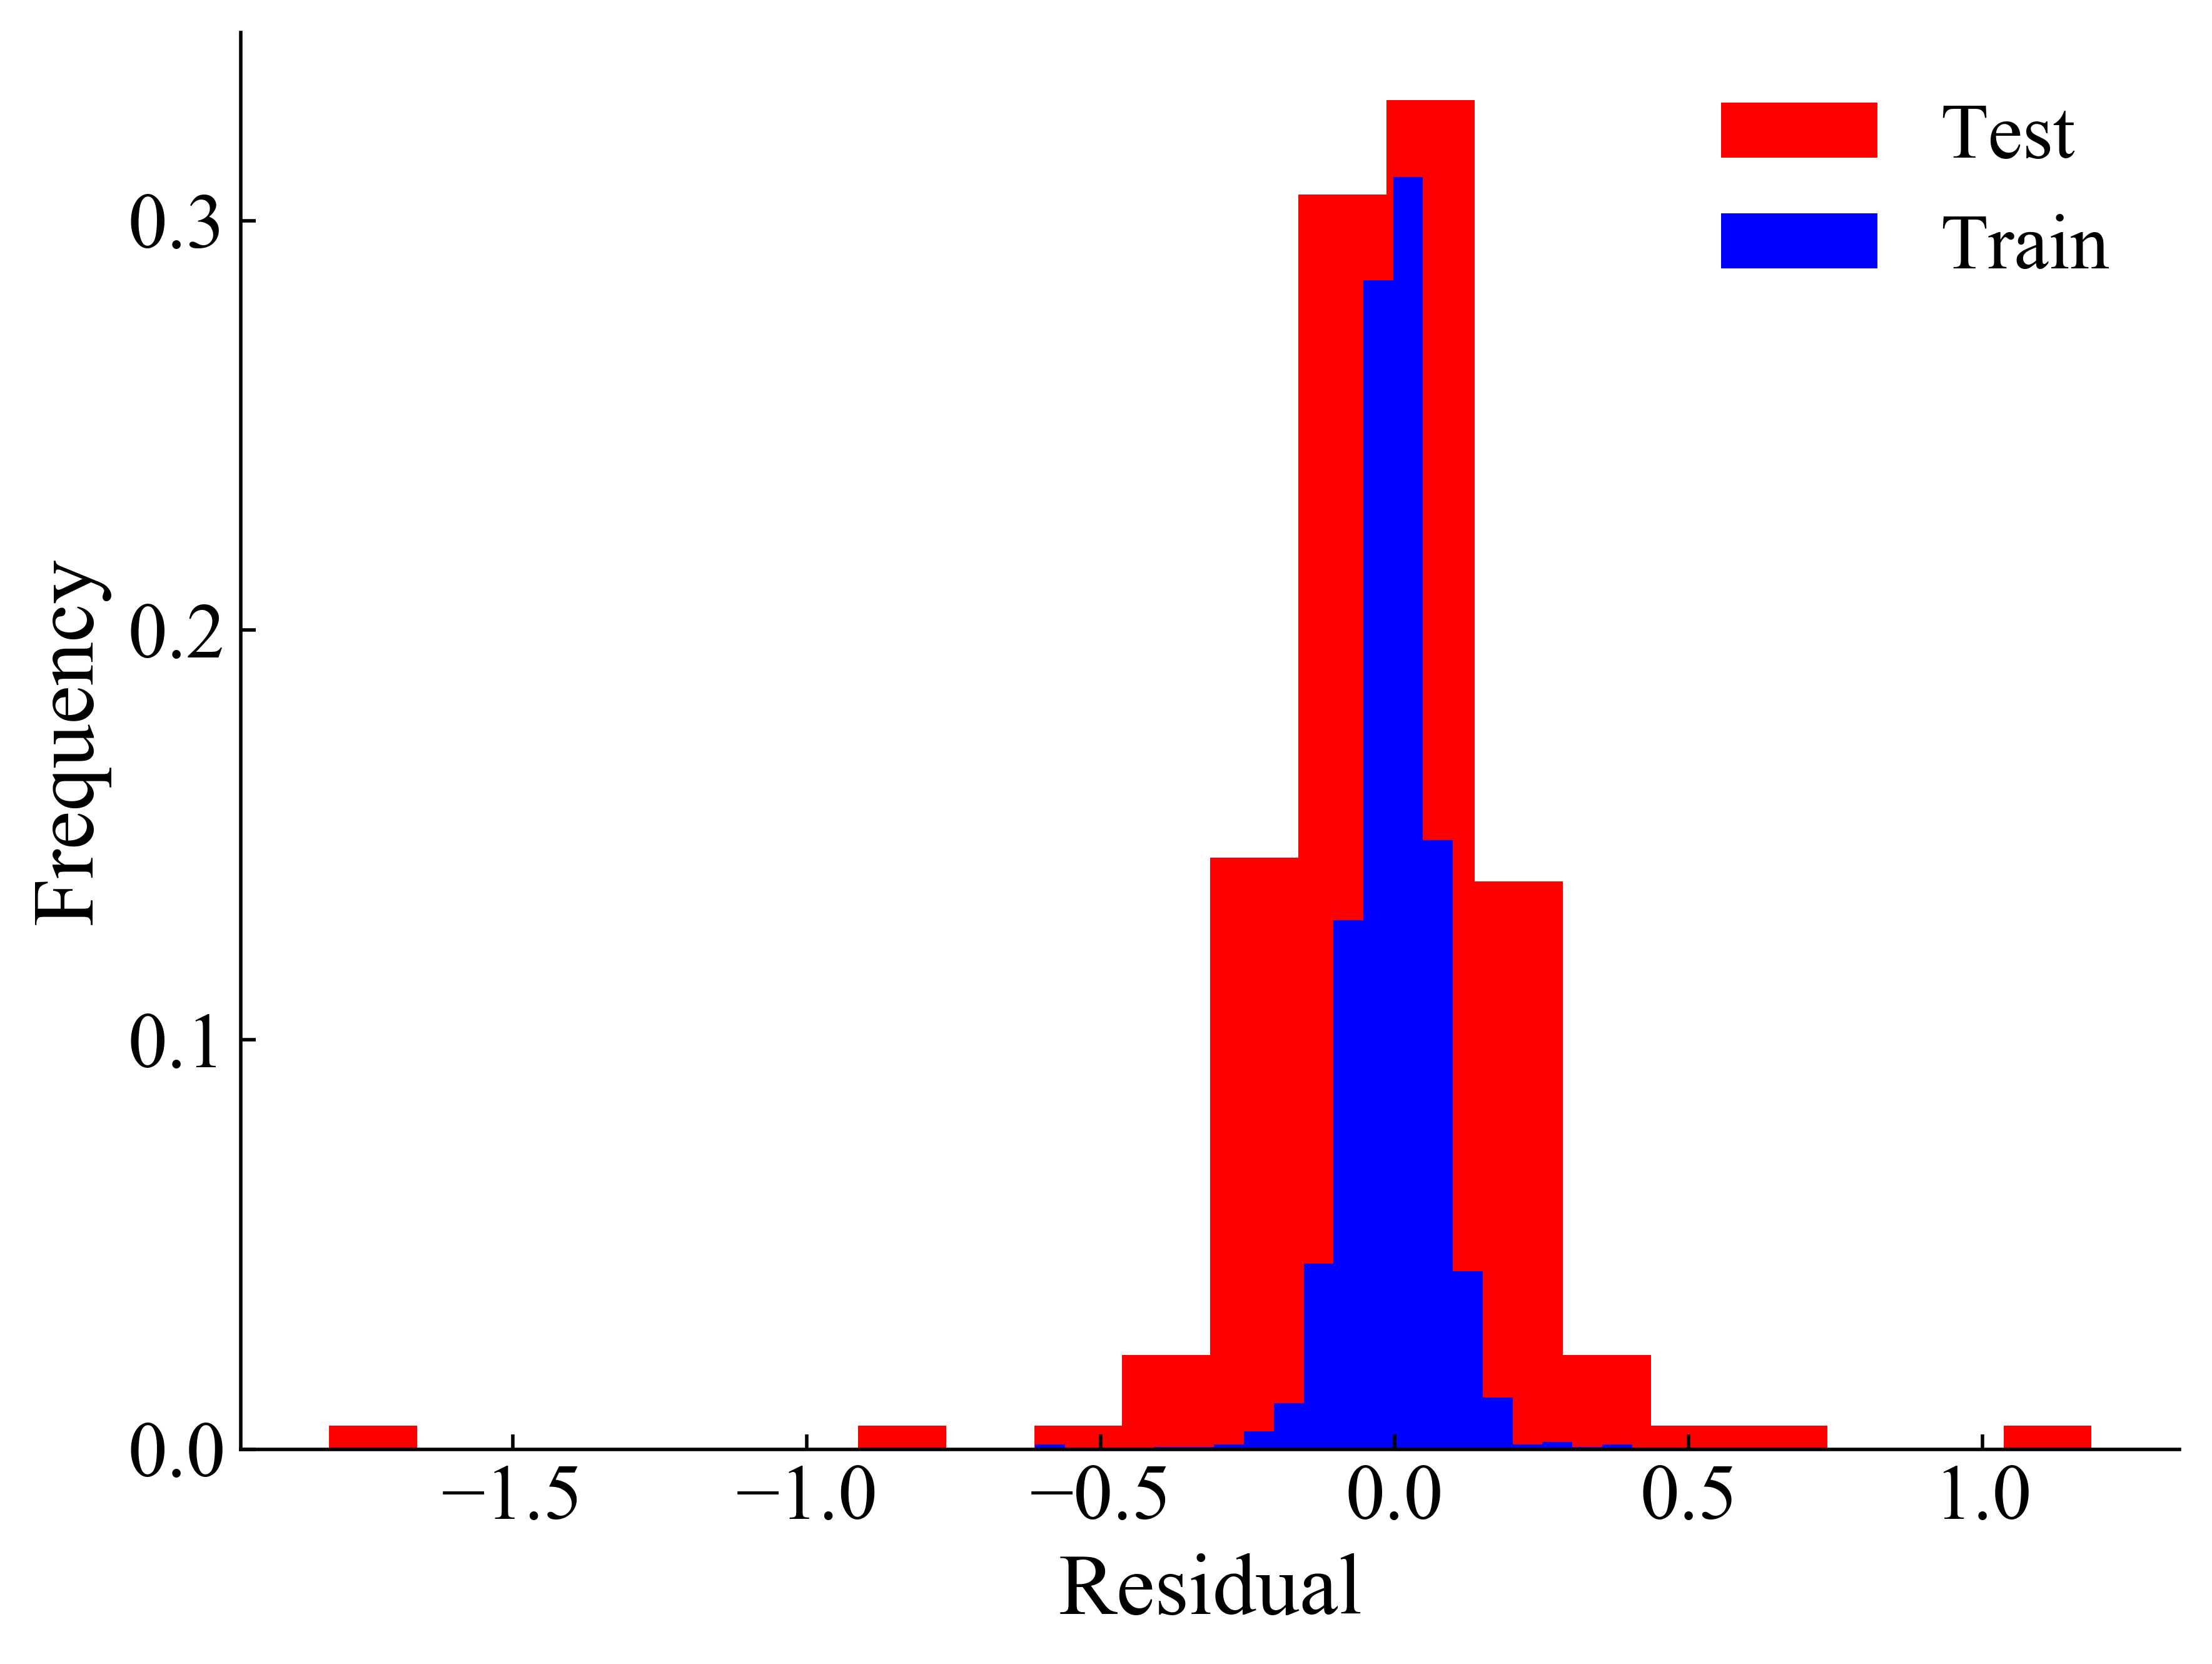

In [11]:
train_resid = reXGB_Complete.predict(X_train)-y_train.iloc[:,3]
test_resid = reXGB_Complete.predict(X_test) - y_test.iloc[:,3]
print(np.mean(test_resid)+2*np.std(test_resid))
font = {'fontname':'Times New Roman', 'size' : 20}
fig, ax = plt.subplots(figsize=(8,6), dpi=500)
ax.hist(test_resid,bins=20, weights = np.ones_like(test_resid)/float(len(test_resid)), label='Test', color='red')
ax.hist(train_resid,bins=20, weights = np.ones_like(train_resid)/float(len(train_resid)), label='Train', color='blue')
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
plt.xticks( fontname = 'Times New Roman', fontsize = 18)
plt.yticks(fontname = 'Times New Roman', fontsize = 18)
plt.locator_params(axis='y', nbins=6)
plt.xlabel('Residual', **font)
plt.ylabel('Frequency', **font)
plt.legend(frameon = False, prop =  {"family":'Times New Roman', "size":18})
sns.despine()

In [18]:
import pickle
os.chdir(r'C:\Users\User\Desktop\XGBoostPipline\Models\MixedTrainTest\Existing')

# with open('Slight.pkl', 'wb') as file:
#     pickle.dump(XGB_Slight, file)
# with open('Moderate.pkl', 'wb') as file:
#     pickle.dump(XGB_Moderate, file)
# with open('Severe.pkl', 'wb') as file:
#     pickle.dump(XGB_Severe, file)
with open('Complete.pkl', 'wb') as file:
    pickle.dump(XGB_Complete, file)




NameError: name 'XGB_Complete' is not defined

In [19]:
import pickle
os.chdir(r'C:\Users\User\Desktop\XGBoostPipline\Models\MixedTrainTest\Retrofit')
# with open('Retrof_Slight_Ratio.pkl', 'wb') as file:
#     pickle.dump(reXGB_Slight, file)
# with open('Retrof_Moderate_Ratio.pkl', 'wb') as file:
#     pickle.dump(reXGB_Moderate, file)
# with open('Retrof_Severe_Ratio.pkl', 'wb') as file:
#     pickle.dump(reXGB_Severe, file)
with open('Retrof_Complete_Ratio.pkl', 'wb') as file:
    pickle.dump(reXGB_Complete, file)